In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import DataLoader, Subset, TensorDataset, clip_grad_norm_
from torchvision import datasets, transforms
from torch.optim import Adam
import torchvision.transforms as T
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from preprocessing import ImageDataset

In [10]:
dataset_path = '~/datasets'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

kwargs = {'num_workers': 2, 'pin_memory': True} 

batch_size = 53

x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-4

epochs = 10

# Model parameters
input_channels = 3
latent_dim = 20

In [62]:
class Encoder(nn.Module):
    def __init__(self, input_channels, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=1)  # Output: (32, 128, 128)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  # Output: (64, 64, 64)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=4, stride=2, padding=1)  # Output: (32, 32, 32)
        self.flatten = nn.Flatten()

        # Output alpha and beta for the Beta distribution
        self.fc_alpha = nn.Linear(32 * 32 * 32, latent_dim)  # Alpha output
        self.fc_beta = nn.Linear(32 * 32 * 32, latent_dim)   # Beta output

        self.relu = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.flatten(x)
        
        # Ensure alpha and beta are positive with ReLU and add a small constant to avoid zeros
        alpha = F.relu(self.fc_alpha(x)) + 1e-3
        beta = F.relu(self.fc_beta(x)) + 1e-3
        alpha.to(DEVICE)
        beta.to(DEVICE)
        return alpha, beta

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_channels):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 32 ** 3)
        self.deconv1 = nn.ConvTranspose2d(32, 64, kernel_size=4, stride=2, padding=1)  # Output: (64, 64, 64)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)  # Output: (32, 128, 128)
        self.deconv3 = nn.ConvTranspose2d(32, output_channels, kernel_size=4, stride=2, padding=1)  # Output: (3, 256, 256)

    def forward(self, z):
        z = torch.clamp(z, min=1e-6, max=1.0)  # Ensure z is within a valid range
        x = F.relu(self.fc(z))
        x = x.view(-1, 32, 32, 32)  # Reshape to spatial dimensions
        x = F.relu(self.deconv1(x))
        x = torch.sigmoid(self.deconv2(x))  # Sigmoid to constrain outputs between 0 and 1
        x = torch.sigmoid(self.deconv3(x))
        return x
class BetaVAE(nn.Module):
    def __init__(self, input_channels, latent_dim):
        super(BetaVAE, self).__init__()
        self.encoder = Encoder(input_channels, latent_dim)
        self.decoder = Decoder(latent_dim, input_channels)

    def reparameterize(self, alpha, beta):
    
        gamma_alpha = torch.distributions.Gamma(alpha, torch.ones_like(alpha)).sample()
        gamma_beta = torch.distributions.Gamma(beta, torch.ones_like(beta)).sample()
    
        z = gamma_alpha / (gamma_alpha + gamma_beta)
        return z.to(DEVICE)

    def forward(self, x):
        alpha, beta = self.encoder(x)
        z = self.reparameterize(alpha, beta)
        reconstructed = self.decoder(z)
        return reconstructed, alpha, beta

def loss_function(reconstructed, original, alpha, beta, beta_weight=1.0):
    device = alpha.device  
    alpha = torch.clamp(alpha, min=1e-6)
    beta = torch.clamp(beta, min=1e-6)
    
    original = original.to(device)  
    
    ones = torch.ones_like(alpha, device=device)  

    reconstruction_loss = F.mse_loss(reconstructed, original, reduction='sum')

    # KL divergence for Beta distribution with prior Beta(1, 1)
    prior = dist.Beta(torch.ones_like(alpha), torch.ones_like(beta))  # Beta(1,1) prior
    q_dist = dist.Beta(alpha, beta)
    kl_divergence = torch.distributions.kl.kl_divergence(q_dist, prior).sum()

    return reconstruction_loss + beta_weight * kl_divergence

In [69]:
# Train on our dataset
image_dataset = ImageDataset("map_images_original/labels.csv", "map_images_original/")

#Split into train and test sets
indices = list(range(len(image_dataset)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)  # 80% train, 20% test
train_dataset = Subset(image_dataset, train_indices)
test_dataset = Subset(image_dataset, test_indices)

# Create a new DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, **kwargs)

# Define model
vae = BetaVAE(input_channels=3, latent_dim=20).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (images, _) in enumerate(train_loader):
        images = images.to(DEVICE)

        optimizer.zero_grad()

        reconstructed, alpha, beta = vae(images)
        loss = loss_function(reconstructed, images, alpha, beta)


        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / (batch_idx*batch_size)}")
    

# Saving the model and optimizer
torch.save({
    'model_state_dict': vae.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, "beta_VAE_checkpoint.pth")

Epoch 1, Loss: 52702.472447710985
Epoch 2, Loss: 52703.48400248647
Epoch 3, Loss: 52701.77310955097
Epoch 4, Loss: 52702.5530568963
Epoch 5, Loss: 52702.481845107504
Epoch 6, Loss: 52702.71539052216
Epoch 7, Loss: 52701.34803276291
Epoch 8, Loss: 52703.62933304081
Epoch 9, Loss: 52703.12370191605
Epoch 10, Loss: 52702.16315635513


In [74]:
test_loader = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False,  **kwargs)

# Reloading the model and optimizer
checkpoint = torch.load("beta_VAE_checkpoint.pth")
vae = BetaVAE(input_channels=input_channels, latent_dim=latent_dim)  # Reinitialize model
vae.load_state_dict(checkpoint['model_state_dict'])
vae.to(DEVICE)
optimizer = torch.optim.Adam(vae.parameters(), lr=lr)  # Reinitialize optimizer
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

vae.eval()
for batch_idx, (test_images, _) in enumerate(test_loader):
    test_images = test_images.to(DEVICE)
    reconstructed, mean, log_var = vae(test_images)
    loss = loss_function(reconstructed, test_images, mean, log_var)
print(loss.item() / batch_size)

C:\Users\Aes\AppData\Local\Temp\ipykernel_3576\2177090270.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("beta_VAE_checkpoint.pth")


42573.89150943396


In [75]:
def show_image(original_batch, reconstructed_batch, index):
    # Extract the specific image and move to CPU
    original = original_batch[index].detach().cpu()
    reconstructed = reconstructed_batch[index].detach().cpu()

    transform = T.Compose([
    T.ToPILImage()
    ])
    
    
    original = transform(original)
    reconstructed = transform(reconstructed)
    
        
    # Create the plot
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    
    # Original image
    axes[0].imshow(original)
    axes[0].set_title("Original")
    axes[0].axis('off')
    
    # Reconstructed image
    axes[1].imshow(reconstructed)
    axes[1].set_title("Generated")
    axes[1].axis('off')
    
    # Display the plot
    plt.tight_layout()
    plt.show()

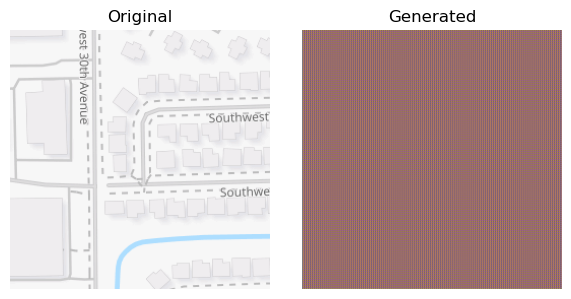

In [98]:
show_image(test_images, reconstructed, index=17)